# Variant effect prediction

In [1]:
import bioframe as bf
from datasets import load_dataset
from functools import reduce
from gpn.data import load_table
import numpy as np
import pandas as pd
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_curve(V, results, curve, title, pos_label="Pathogenic", pos_prop=None, save_path=None):
    if curve == "ROC":
        plot_f = RocCurveDisplay
        metric = "AUROC"
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        random_plot = lambda ax: ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    elif curve == "PR":
        plot_f = PrecisionRecallDisplay
        metric = "AUPRC"
        xlabel = 'Recall'
        ylabel = 'Precision'
        random_plot = lambda ax: ax.axhline(y=pos_prop, linestyle="--", color="gray")
    
    # note: latest sklearn has argument: plot_chance_level
    fig, ax = plt.subplots(figsize=(3,3))

    for m in results.Model.unique()[::-1]:
        AUC = results[results.Model==m].iloc[0][metric]
        plot_f.from_predictions(V.label==pos_label, -V[m], name=m, ax=ax, label=f"{m} (AUC={AUC:.3f})", color=palette[m])
        
    random_plot(ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.despine()
    
    ax.legend();
    # get handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # reverse the order
    handles, labels = handles[::-1], labels[::-1]
    # create the legend with the reversed order
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(title);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        

color_neg = sns.color_palette("Dark2")[0]
color_pos = sns.color_palette("Dark2")[1]
palette_label = {
    "gnomAD/\nCommon": color_neg,
    "ClinVar/\nPathogenic": color_pos,
    "COSMIC/\nFrequent": color_pos,
    "OMIM/\nPathogenic": color_pos,
    "gnomAD/\nRare": color_pos,
    
    "Common": color_neg,
    "Rare": color_pos,
}

def barplot(df, metric, title, pos_prop=None, save_path=None, figsize=(3,3)):
    plt.figure(figsize=figsize)
    g = sns.barplot(
        data=df.sort_values(metric, ascending=False),
        y="Model",
        x=metric,
        palette=palette,
    )
    sns.despine();
    plt.title(title, fontsize=11);
    baseline = 0.5 if metric == "AUROC" else pos_prop
    g.set(xlim=baseline)
    plt.ylabel("");

    for bar in g.patches:
        g.text(
            bar.get_width(),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

def histplot_label(V, save_path=None, **kwargs):
    V["Label"] = V.source + "/\n" + V.label
    plt.figure(figsize=(3,3))
    g = sns.histplot(
        data=V,
        x="GPN-MSA",
        hue="Label",
        bins=25,
        stat="density",
        common_norm=False,
        common_bins=True,
        palette=palette_label,
        **kwargs,
    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        
        
def ecdfplot_label(V, save_path=None, **kwargs):
    plt.figure(figsize=(3,3))
    sns.ecdfplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        palette=palette_label,
        **kwargs,
    )
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

In [3]:
plot_dir = "../../results/plots/"

In [4]:
palette = {
    "GPN-MSA": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT": "C4",
    "SpliceAI": "C5",
    "Enformer": "C6",
    "HyenaDNA": "C9",
    
    "phyloP-100-vertebrates": "C2",
    "phyloP-241-mammals": "C7",
    "phastCons-100-vertebrates": "C8",
    
    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    
    r"Enformer ($L^1$)": "C7",
    r"Enformer ($L^2$)": "C6",
    r"Enformer ($L^\infty$)": "C8",
    
    "GPN-MSA + Enformer": "black",
}

In [81]:
core_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "CADD.RawScore",
    "phyloP",
    "phyloP-Zoonomia",
    "phastCons",
]

nt_models = [
    "InstaDeepAI/nucleotide-transformer-500m-human-ref",
    "InstaDeepAI/nucleotide-transformer-500m-1000g",
    "InstaDeepAI/nucleotide-transformer-2.5b-1000g",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
]

hyenadna_models = [
    #'LongSafari/hyenadna-tiny-1k-seqlen-hf',
    #'LongSafari/hyenadna-small-32k-seqlen-hf',
    #'LongSafari/hyenadna-medium-160k-seqlen-hf',
    #'LongSafari/hyenadna-medium-450k-seqlen-hf',
    'LongSafari/hyenadna-large-1m-seqlen-hf',    
]

ablation_models = pd.read_csv("../../models.txt", header=None).values.ravel().tolist()[1:]
ablation_models = ["msa_multiz100way/89"]

model_renaming = { 
    # GPN-MSA
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    
    # NT models
    "InstaDeepAI/nucleotide-transformer-500m-human-ref": "NT-500m-human-ref",
    "InstaDeepAI/nucleotide-transformer-500m-1000g": "NT-500m-1000g",
    "InstaDeepAI/nucleotide-transformer-2.5b-1000g": "NT-2.5b-1000g",
    #"InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT-2.5b-multi-species",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    
    # HyenaDNA models
    'LongSafari/hyenadna-large-1m-seqlen-hf': "HyenaDNA",
    
    # Other models
    "CADD.RawScore": "CADD",
    #"phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

def gather_unique_values(d):
    unique_values = []
    seen = set()

    def gather_values(nested_dict):
        for value in nested_dict.values():
            if isinstance(value, dict):
                gather_values(value)
            elif isinstance(value, list):
                for item in value:
                    if item not in seen:
                        unique_values.append(item)
                        seen.add(item)

    gather_values(d)

    return unique_values

def apply_to_values(d, f):
    for key, value in d.items():
        if isinstance(value, dict):
            apply_to_values(value, f)
        elif isinstance(value, list):
            d[key] = [f(x) for x in value]
        else:
            d[key] = f(value)

dataset_models = {
    "ClinVar": core_models + nt_models + hyenadna_models + ["ESM-1b"] + ablation_models,

    "COSMIC": core_models + ["ESM-1b"] + nt_models[-1:]+ ablation_models,

    "OMIM": {
        "all": core_models + ablation_models,
        "Promoter": core_models,
        "Enhancer": core_models,
        "5' UTR": core_models + nt_models[-1:],
        "3' UTR": core_models + nt_models[-1:],
        "ncRNA": core_models,
    },
    
    "gnomAD": {
        "all": core_models + ablation_models,
        
        "missense": core_models + ["ESM-1b"] + nt_models[-1:],
        
        "synonymous": core_models + nt_models[-1:],
        "5_prime_UTR": core_models + nt_models[-1:],
        "3_prime_UTR": core_models + nt_models[-1:],
        "upstream_gene": core_models,
        "downstream_gene": core_models,
        
        "intron": core_models  + ["SpliceAI"],
        
        "intergenic": core_models,
        "non_coding_transcript_exon": core_models,
    },
}
models = gather_unique_values(dataset_models)

In [30]:
dataset_path = "songlab/human_variants"
V = load_dataset(dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(models):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
V

Repo card metadata block was not found. Setting CardData to empty.
100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,phyloP-241-mammals,phastCons-100-vertebrates,NT-500m-human-ref,NT-500m-1000g,NT-2.5b-1000g,NT,HyenaDNA,ESM-1b,msa_multiz100way/89,SpliceAI
0,1,14731,G,A,Rare,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,-1.922,-0.066,NaN,NaN,NaN,NaN,NaN,NaN,-3.044522,NaN
1,1,16487,T,C,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,1.811,-0.692,NaN,NaN,NaN,NaN,NaN,NaN,-2.197225,NaN
2,1,62015,C,G,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,-0.311,-0.007,NaN,NaN,NaN,NaN,NaN,NaN,-1.098612,NaN
3,1,62046,A,T,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,-0.249,-0.001,NaN,NaN,NaN,NaN,NaN,NaN,-0.916291,NaN
4,1,64866,T,G,Rare,gnomAD,"downstream_gene_variant,upstream_gene_variant",None,None,None,...,-0.299,-0.001,NaN,NaN,NaN,NaN,NaN,NaN,-3.091042,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9761262,Y,2787426,C,G,Pathogenic,ClinVar,missense_variant,9739,"criteria_provided,_single_submitter",None,...,-5.114,-1.000,0.152820,-0.199322,0.070564,0.022049,4.976988e-06,-9.000,-3.806662,-0.00
9761263,Y,2787515,C,A,Pathogenic,ClinVar,missense_variant,492908,no_assertion_criteria_provided,None,...,-0.120,-0.000,-1.112572,-0.721853,-1.072739,-2.884125,2.861023e-06,-4.780,-1.098612,-0.01
9761264,Y,2787551,C,T,Pathogenic,ClinVar,missense_variant,9754,no_assertion_criteria_provided,None,...,-0.120,-0.989,0.116755,0.125798,0.117401,0.072632,-2.950430e-06,-4.299,1.252763,-0.00
9761265,Y,2787678,C,T,Pathogenic,OMIM,Enhancer Mutations,None,None,None,...,-0.120,-0.001,NaN,NaN,NaN,0.064789,NaN,NaN,0.000000,-0.00


In [160]:
dataset_path = "results/variants_enformer/"
V_enformer = pd.read_parquet("../../" + dataset_path + "test.parquet")
d = Path(f"../../results/preds/{dataset_path}")

models_enformer = core_models + [
    "Enformer_l1", "Enformer_l2", "Enformer_linf"
]

for m in tqdm(models_enformer):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_enformer[model_name] = pd.read_parquet(model_path)["score"].values
V_enformer

100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


,chrom,pos,ref,alt,AC,AN,AF,consequence,MAF,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True,CADD,phyloP,phyloP-241-mammals,phastCons-100-vertebrates,Enformer_l1,Enformer_l2,Enformer_linf
0,1,61993,C,T,754,140936,0.005350,"intron_variant&non_coding_transcript_variant,u...",0.005350,-0.825195,-0.293977,0.640,-0.311,-0.003,-3.689453,-0.080139,-0.012398
1,1,64649,A,C,2523,140200,0.017996,"downstream_gene_variant,upstream_gene_variant",0.017996,-2.369141,-0.241779,-0.034,-0.107,-0.001,-1.554688,-0.033447,-0.004086
2,1,108869,G,T,779,150338,0.005182,"downstream_gene_variant,intron_variant&non_cod...",0.005182,-1.368164,-0.141906,-0.028,0.000,-0.001,-1.117188,-0.024780,-0.003456
3,1,109503,G,A,1224,149682,0.008177,"downstream_gene_variant,intron_variant&non_cod...",0.008177,-1.751953,-0.247377,-0.740,1.351,-0.003,-0.847168,-0.016434,-0.001889
4,1,115746,C,T,5936,146996,0.040382,"TF_binding_site_variant,downstream_gene_varian...",0.040382,-0.967773,-0.150182,-0.368,-0.338,-0.004,-3.269531,-0.064819,-0.003838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383063,22,50795915,G,T,8197,151596,0.054071,"intron_variant&non_coding_transcript_variant,u...",0.054071,0.745605,0.602580,2.806,-0.092,-0.007,-1.449219,-0.033478,-0.007637
6383064,22,50796371,G,A,1414,140624,0.010055,"intron_variant&non_coding_transcript_variant,r...",0.010055,0.369141,0.084790,-0.190,-0.337,-0.019,-4.253906,-0.100342,-0.020645
6383065,22,50796466,C,T,1182,150168,0.007871,"intron_variant&non_coding_transcript_variant,r...",0.007871,1.945312,0.080695,1.113,0.872,-0.004,-3.597656,-0.088745,-0.026398
6383066,22,50797531,T,C,18143,144892,0.125217,"intron_variant&non_coding_transcript_variant,u...",0.125217,-2.318359,-0.515404,-0.181,-0.133,-0.301,-0.929688,-0.023956,-0.006439


In [82]:
dataset_path = "results/gwas/matched/"
V_gwas = pd.read_parquet("../../" + dataset_path + "test.parquet")
d = Path(f"../../results/preds/{dataset_path}")

models_gwas = core_models + [
    f"{m}.LogisticRegression"
    for m in [
        core_models[0], "Enformer", nt_models[-1], hyenadna_models[-1],
        core_models[0] + "/concat/Enformer",
    ] #+ ablation_models
    #if m != "msa_multiz100way/89"
] + [
    core_models[0] + ".BestFeature",
    core_models[0] + ".SumFeatures",
]

for m in tqdm(models_gwas):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_gwas[model_name] = pd.read_parquet(model_path)["score"].values
V_gwas

100%|██████████| 12/12 [00:00<00:00, 45.57it/s]


,chrom,pos,ref,alt,pip,maf,trait,label,consequence,tss_dist,...,phyloP,phyloP-241-mammals,phastCons-100-vertebrates,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,Enformer.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True/concat/Enformer.LogisticRegression,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.BestFeature,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.SumFeatures
0,1,930312,C,G,0.001963,0.000683,,False,missense_variant,0,...,-2.384,-2.635,-0.050,NaN,NaN,NaN,NaN,NaN,NaN,99190.500000
1,1,976215,A,G,0.005418,0.199367,,False,missense_variant,2703,...,-0.054,0.421,-0.000,-0.524788,-0.787560,-0.542159,-0.587090,-0.885434,95.918259,99026.210938
2,1,1134063,G,A,0.002809,0.388558,,False,upstream_gene_variant,17702,...,-0.472,2.918,-0.007,-0.388078,-0.413033,-0.558475,-0.559563,-0.380648,388.949432,99647.500000
3,1,1203822,T,C,0.006379,0.059558,,False,synonymous_variant,1856,...,0.363,0.160,-0.000,-0.640320,-0.564249,-0.632516,-0.591864,-0.607423,138.199005,99607.976562
4,1,1224844,C,T,0.001119,0.096291,,False,intron_variant,3750,...,0.627,1.080,-0.007,-0.282662,-0.398940,-0.385535,-0.596444,-0.259030,573.323853,99251.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,22,50190508,G,A,1.000000,0.073316,Plt,True,intron_variant,88,...,-0.408,-0.752,-0.022,-0.667385,-0.974764,-0.374464,-0.486098,-0.977951,193.183807,99661.515625
4590,22,50309599,G,A,0.002612,0.005661,,False,3_prime_UTR_variant,1953,...,-0.279,-0.035,-0.002,NaN,NaN,NaN,NaN,NaN,NaN,99628.929688
4591,22,50395752,A,G,0.001928,0.083293,,False,intron_variant,23680,...,0.404,0.367,-0.005,-0.400223,-0.397806,-0.506101,-0.402324,-0.338573,361.131042,99278.945312
4592,22,50516206,G,A,0.978163,0.095820,MCH,True,intron_variant,6317,...,-1.240,-1.308,-0.004,-0.497405,-0.484222,-0.387195,-0.731994,-0.476777,255.331635,99735.132812


In [83]:
models = [model_renaming.get(m, m) for m in models]
models_gwas = [model_renaming.get(m, m) for m in models_gwas]
models_enformer = [model_renaming.get(m, m) for m in models_enformer]
models

NameError: name 'models_enformer' is not defined

In [32]:
apply_to_values(dataset_models, lambda m: model_renaming.get(m, m))

## ClinVar pathogenic vs. gnomAD common (missense)

In [33]:
V_clinvar = V[
    (V.source == "ClinVar") |
    (
        (V.label == "Common") &
        V.consequence.str.contains("missense")
    )
].copy()
V_clinvar.dropna(subset=dataset_models["ClinVar"], inplace=True)
V_clinvar.label.value_counts()

label
Pathogenic    21275
Common        13117
Name: count, dtype: int64

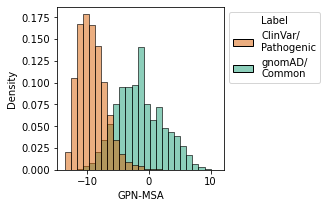

In [10]:
histplot_label(
    V_clinvar,
    hue_order=["ClinVar/\nPathogenic", "gnomAD/\nCommon"],
    #save_path="hist_clinvar.svg",
)

In [16]:
rows = []
for m in tqdm(dataset_models["ClinVar"]):
    y_true = V_clinvar.label=="Pathogenic"
    y_score = -V_clinvar[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append([m, AUROC, AUPRC])
results_clinvar = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"]).sort_values("AUROC", ascending=False)
results_clinvar

100%|██████████| 56/56 [00:01<00:00, 36.29it/s]


,Model,AUROC,AUPRC
28,multiz100way/89/256/128/True/defined.phastCons...,0.966573,0.977901
12,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.977794
30,multiz100way/89/256/128/True/defined.phastCons...,0.966203,0.977623
29,multiz100way/89/256/128/True/defined.phastCons...,0.966161,0.977664
0,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.977555
11,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.977538
54,multiz100way/89/128/64/True/defined.phastCons....,0.965504,0.977112
53,multiz100way/89/128/64/True/defined.phastCons....,0.965352,0.976988
52,multiz100way/89/128/64/True/defined.phastCons....,0.965173,0.976840
36,multiz100way/89/128/64/True/defined.phastCons....,0.964764,0.976415


In [17]:
n_pos, n_neg = (V_clinvar.label=="Pathogenic").sum(), (V_clinvar.label=="Common").sum()
clinvar_title = f"ClinVar pathogenic vs.\ngnomAD common (missense)\nn={n_pos} vs. {n_neg}"
pos_prop = n_pos/(n_pos+n_neg)
clinvar_title

'ClinVar pathogenic vs.\ngnomAD common (missense)\nn=21275 vs. 13117'

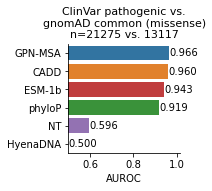

In [19]:
barplot(
    results_clinvar[results_clinvar.Model.isin([
        models[0], "CADD", "phyloP", "NT", "HyenaDNA", "ESM-1b",
    ])].replace(models[0], "GPN-MSA"),
    "AUROC",
    clinvar_title,
    figsize=(2,2),
    #save_path="clinvar_auroc.svg",
)

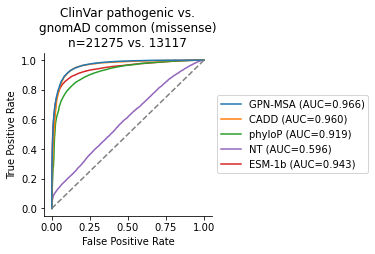

In [19]:
plot_curve(
    V_clinvar,
    results_clinvar[results_clinvar.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
    ])],
    "ROC",
    title,
    #save_path="clinvar_roc.svg",
)

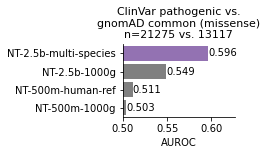

In [21]:
barplot(
    results_clinvar[results_clinvar.Model.isin([
         "NT-500m-human-ref", "NT-500m-1000g", "NT-2.5b-1000g", "NT",
    ])].replace("NT", "NT-2.5b-multi-species"),
    "AUROC",
    clinvar_title,
    figsize=(2,2*2/3),
    #save_path="clinvar_auroc_NT.pdf",
)

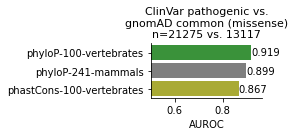

In [24]:
barplot(
    results_clinvar[results_clinvar.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    "AUROC",
    clinvar_title,
    figsize=(2,2*1/2),
    #save_path="clinvar_auroc_conservation.svg"
)

### Stratifying by conservation

In [25]:
log_pval_thresh = -np.log10(0.05)  # 1.3
V_clinvar["conservation"] = "neutral"
V_clinvar.loc[V_clinvar.phyloP < -log_pval_thresh, "conservation"] = "conserved"
V_clinvar.loc[V_clinvar.phyloP > log_pval_thresh, "conservation"] = "accelerated"
V_clinvar.conservation.value_counts()

conservation
conserved      24369
neutral         8633
accelerated     1390
Name: count, dtype: int64

In [27]:
rows = []
for c in V_clinvar.conservation.unique():
    V_c = V_clinvar[V_clinvar.conservation==c]
    for m in dataset_models["ClinVar"]:
        AUROC = roc_auc_score(V_c.label=="Pathogenic", -V_c[m])
        AUPRC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
        rows.append([c, m, AUROC, AUPRC])
results_clinvar_strat = pd.DataFrame(rows, columns=["Conservation", "Model", "AUROC", "AUPRC"])
results_clinvar_strat

,Conservation,Model,AUROC,AUPRC
0,neutral,GPN-MSA,0.916170,0.780884
1,neutral,CADD,0.895336,0.714260
2,neutral,phyloP,0.663319,0.254761
3,neutral,phyloP-241-mammals,0.637950,0.302476
4,neutral,phastCons-100-vertebrates,0.769634,0.394395
5,neutral,NT-500m-human-ref,0.499749,0.151674
6,neutral,NT-500m-1000g,0.481755,0.145583
7,neutral,NT-2.5b-1000g,0.526618,0.159958
8,neutral,NT,0.572771,0.202702
9,neutral,ESM-1b,0.882713,0.764948


In [63]:
def get_subtitle(c):
    n_pos, n_neg = V_clinvar[V_clinvar.conservation==c].label.value_counts()[["Pathogenic", "Common"]].values
    return f"{c} (n={n_pos} vs. {n_neg})"

results_clinvar_strat["subtitle"] = results_clinvar_strat.Conservation.apply(get_subtitle)
results_clinvar_strat

,Conservation,Model,AUROC,AUPRC,subtitle
0,neutral,GPN-MSA,0.916170,0.780884,neutral (n=1371 vs. 7262)
1,neutral,CADD,0.895336,0.714260,neutral (n=1371 vs. 7262)
2,neutral,phyloP,0.663319,0.254761,neutral (n=1371 vs. 7262)
3,neutral,phyloP-241-mammals,0.637950,0.302476,neutral (n=1371 vs. 7262)
4,neutral,phastCons-100-vertebrates,0.769634,0.394395,neutral (n=1371 vs. 7262)
5,neutral,NT-500m-human-ref,0.499749,0.151674,neutral (n=1371 vs. 7262)
6,neutral,NT-500m-1000g,0.481755,0.145583,neutral (n=1371 vs. 7262)
7,neutral,NT-2.5b-1000g,0.526618,0.159958,neutral (n=1371 vs. 7262)
8,neutral,NT,0.572771,0.202702,neutral (n=1371 vs. 7262)
9,neutral,ESM-1b,0.882713,0.764948,neutral (n=1371 vs. 7262)


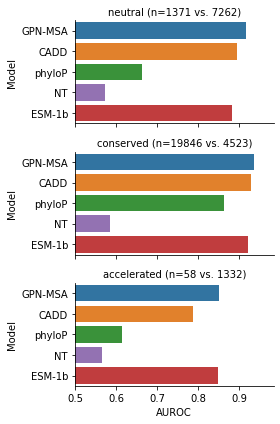

In [66]:
g = sns.catplot(
    data=results_clinvar_strat[
        results_clinvar_strat.Model.isin([
            "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
        ])
    ],
    x="AUROC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
)
g.set_titles(row_template="{row_name}")
g.set(xlim=0.5);

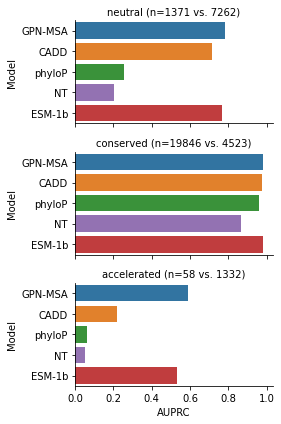

In [69]:
g = sns.catplot(
    data=results_clinvar_strat[
        results_clinvar_strat.Model.isin([
            "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
        ])
    ],
    x="AUPRC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
)
g.set_titles(row_template="{row_name}");
#g.set(xlim=0.5);

In [43]:
for m in dataset_models["ClinVar"]:
    V_clinvar[f"{m}_rank"] = V_clinvar[m].rank()

In [63]:
V_clinvar["other_models_rank"] = V_clinvar[[f"{m}_rank" for m in [
    #"CADD",
    #"phyloP",
    "msa_multiz100way/89",
    #"phyloP-241-mammals"
]]].min(axis=1)

In [64]:
V_clinvar["delta_rank"] = V_clinvar[f"GPN-MSA_rank"] - V_clinvar["other_models_rank"]

In [65]:
V_clinvar[V_clinvar.label == "Pathogenic"].sort_values("delta_rank")[[c for c in V_clinvar.columns if 'rank' in c or c in ['chrom', 'pos', 'ref', 'alt']]]

,chrom,pos,ref,alt,GPN-MSA_rank,CADD_rank,phyloP_rank,phyloP-241-mammals_rank,phastCons-100-vertebrates_rank,NT-500m-human-ref_rank,NT-500m-1000g_rank,NT-2.5b-1000g_rank,NT_rank,HyenaDNA_rank,ESM-1b_rank,msa_multiz100way/89_rank,other_models_rank,delta_rank
1114590,2,104856594,C,A,6126.0,12110.0,23548.5,9038.0,10692.5,14852.0,22536.0,14833.0,7162.0,29297.0,943.5,28291.0,28291.0,-22165.0
7637753,14,28768076,T,A,280.0,2123.0,16984.5,20338.5,10692.5,4007.0,13132.0,8522.0,9975.0,29759.5,2075.0,21568.0,21568.0,-21288.0
9760023,X,101358408,A,T,5660.5,12649.0,16680.0,18752.5,10692.5,20575.0,21885.0,22545.0,18523.0,24357.0,666.0,26891.0,26891.0,-21230.5
9480898,20,63472178,G,T,569.0,7116.0,12883.0,9002.5,10692.5,29562.0,25861.0,12827.0,27485.0,4702.5,1705.0,21033.5,21033.5,-20464.5
3744536,6,31962012,T,G,2050.0,7830.0,18168.0,12631.5,10692.5,20746.0,14877.0,18037.0,5622.0,8881.5,9364.5,22051.5,22051.5,-20001.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518202,11,64757826,C,T,21760.5,16431.0,7812.5,1170.0,10692.5,28590.0,28569.0,29794.0,23958.0,29759.5,9296.5,1214.0,1214.0,20546.5
1303523,2,162281498,C,T,22330.5,21107.0,7812.5,1987.5,10692.5,23915.0,24075.0,22324.0,18240.0,20294.5,24385.5,1214.0,1214.0,21116.5
7778569,14,67729229,G,A,22499.5,22255.0,320.0,10775.5,10692.5,29472.0,29119.0,32901.0,32700.0,19383.0,22046.5,1214.0,1214.0,21285.5
9275868,20,3233949,G,A,22621.0,3040.0,320.0,6234.0,10692.5,22413.0,27261.0,26802.0,25822.0,13679.5,21673.0,1214.0,1214.0,21407.0


In [27]:
V_clinvar[(V_clinvar.label == "Pathogenic") & (V_clinvar.phyloP > -1)].sort_values(models[0])

,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,phyloP-241-mammals_rank,phastCons-100-vertebrates_rank,NT-500m-human-ref_rank,NT-500m-1000g_rank,NT-2.5b-1000g_rank,NT_rank,HyenaDNA_rank,ESM-1b_rank,other_models_rank,delta_rank
7893636,14,99175513,A,C,Pathogenic,ClinVar,missense_variant,254673,no_assertion_criteria_provided,None,...,29738.5,10692.5,34336.0,34324.0,28885.0,14214.0,19383.0,814.5,21663.80,-17912.80
8666365,17,56594722,C,G,Pathogenic,ClinVar,missense_variant,6702,no_assertion_criteria_provided,None,...,10726.0,10692.5,10667.0,9492.0,22000.0,20651.0,17605.0,6882.0,14368.50,-9258.50
6865277,12,25245370,T,A,Pathogenic,ClinVar,missense_variant,12594,reviewed_by_expert_panel,None,...,24160.0,10692.5,10993.0,14046.0,10363.0,5698.0,10766.5,12072.0,14240.90,-9130.90
6865171,12,25225713,T,A,Pathogenic,ClinVar,missense_variant,375964,no_assertion_criteria_provided,None,...,26660.5,10692.5,10317.0,10525.0,11478.0,15789.0,16710.5,7482.5,15248.55,-9850.05
8521831,17,8014700,C,G,Pathogenic,ClinVar,missense_variant,1685873,"criteria_provided,_single_submitter",None,...,3212.0,21561.0,24134.0,26092.0,13557.0,7838.0,24357.0,19478.5,17702.30,-11925.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606326,14,20693728,G,A,Pathogenic,ClinVar,"intron_variant,missense_variant",18076,no_assertion_criteria_provided,None,...,34328.0,31949.5,22638.0,15515.0,29612.5,27745.0,19383.0,28612.5,27768.80,3429.20
3240382,5,75596726,C,T,Pathogenic,ClinVar,"missense_variant,non-coding_transcript_variant",218222,"criteria_provided,_single_submitter",None,...,26952.5,29205.5,26425.0,25082.0,13123.0,9294.0,21166.5,23922.5,23014.05,8636.45
6800872,12,7690389,C,T,Pathogenic,ClinVar,missense_variant,30593,no_assertion_criteria_provided,None,...,34189.0,31949.5,32239.0,32765.0,32932.0,31877.0,33710.5,31025.5,32777.50,-838.50
6709567,11,118141265,G,A,Pathogenic,ClinVar,"missense_variant,non-coding_transcript_variant",2459,no_assertion_criteria_provided,None,...,30565.0,23709.0,23077.0,22438.0,16110.0,15058.0,8881.5,22019.5,21991.55,10128.45


In [28]:
V_clinvar[(V_clinvar.label == "Pathogenic") & (V_clinvar.phyloP > -1)].sort_values(models[0])[[c for c in V_clinvar.columns if 'rank' in c or c in ['chrom', 'pos', 'ref', 'alt']]]

,chrom,pos,ref,alt,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True_rank,CADD_rank,phyloP_rank,phyloP-241-mammals_rank,phastCons-100-vertebrates_rank,NT-500m-human-ref_rank,NT-500m-1000g_rank,NT-2.5b-1000g_rank,NT_rank,HyenaDNA_rank,ESM-1b_rank,other_models_rank,delta_rank
7893636,14,99175513,A,C,3751.0,18906.0,25344.5,29738.5,10692.5,34336.0,34324.0,28885.0,14214.0,19383.0,814.5,21663.80,-17912.80
8666365,17,56594722,C,G,5110.0,9598.0,25371.5,10726.0,10692.5,10667.0,9492.0,22000.0,20651.0,17605.0,6882.0,14368.50,-9258.50
6865277,12,25245370,T,A,5110.0,17401.0,26217.0,24160.0,10692.5,10993.0,14046.0,10363.0,5698.0,10766.5,12072.0,14240.90,-9130.90
6865171,12,25225713,T,A,5398.5,17410.0,25420.5,26660.5,10692.5,10317.0,10525.0,11478.0,15789.0,16710.5,7482.5,15248.55,-9850.05
8521831,17,8014700,C,G,5776.5,10480.0,26313.5,3212.0,21561.0,24134.0,26092.0,13557.0,7838.0,24357.0,19478.5,17702.30,-11925.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606326,14,20693728,G,A,31198.0,33694.0,34210.5,34328.0,31949.5,22638.0,15515.0,29612.5,27745.0,19383.0,28612.5,27768.80,3429.20
3240382,5,75596726,C,T,31650.5,29288.0,25681.5,26952.5,29205.5,26425.0,25082.0,13123.0,9294.0,21166.5,23922.5,23014.05,8636.45
6800872,12,7690389,C,T,31939.0,34046.0,33041.5,34189.0,31949.5,32239.0,32765.0,32932.0,31877.0,33710.5,31025.5,32777.50,-838.50
6709567,11,118141265,G,A,32120.0,28664.0,29393.5,30565.0,23709.0,23077.0,22438.0,16110.0,15058.0,8881.5,22019.5,21991.55,10128.45


In [42]:
V_clinvar[(V_clinvar.label == "Pathogenic") & (V_clinvar["msa_multiz100way/89"] > -4)].sort_values("GPN-MSA")[[c for c in V_clinvar.columns if 'rank' in c or c in ['chrom', 'pos', 'ref', 'alt']]].head(10)

,chrom,pos,ref,alt,GPN-MSA_rank,CADD_rank,phyloP_rank,phyloP-241-mammals_rank,phastCons-100-vertebrates_rank,NT-500m-human-ref_rank,NT-500m-1000g_rank,NT-2.5b-1000g_rank,NT_rank,HyenaDNA_rank,ESM-1b_rank,msa_multiz100way/89_rank
7637753,14,28768076,T,A,280.0,2123.0,16984.5,20338.5,10692.5,4007.0,13132.0,8522.0,9975.0,29759.5,2075.0,21568.0
8666374,17,56594887,T,G,397.0,2743.0,15210.5,20198.0,10692.5,21294.0,23169.0,25260.0,25374.0,26737.0,1673.0,19657.0
7637758,14,28768457,C,G,517.5,9164.0,18996.5,5310.5,10692.5,9021.0,25925.0,9042.0,5489.0,31242.0,17394.5,19934.5
9480749,20,63444702,C,A,546.5,15089.0,15352.0,8120.0,10692.5,6305.0,6249.0,10012.0,16933.0,2791.0,5144.0,19657.0
9480898,20,63472178,G,T,569.0,7116.0,12883.0,9002.5,10692.5,29562.0,25861.0,12827.0,27485.0,4702.5,1705.0,21033.5
6290348,11,533877,C,A,726.0,17215.0,15263.0,20548.0,10692.5,17776.0,13999.0,13727.0,10279.5,3553.5,4273.5,19934.5
3464465,5,140114693,G,C,796.5,1226.0,6905.0,6559.5,10692.5,7388.0,9262.0,3837.0,8278.0,10005.5,34.0,19325.0
6298433,11,2572033,T,A,952.5,14396.0,15797.5,18364.5,10692.5,21782.0,15508.0,17918.0,12762.0,32174.5,42.0,20237.0
1749384,3,46902768,T,G,971.0,2614.0,14417.5,15486.5,10692.5,29046.0,27618.0,20600.5,22562.0,4702.5,3568.0,19173.5
9759992,X,100408524,A,G,1035.0,8195.0,12318.5,19085.5,10692.5,9163.0,10737.0,8910.0,11440.5,26737.0,10093.5,20149.0


In [41]:
V_clinvar[(V_clinvar.label == "Pathogenic") & (V_clinvar["phyloP-241-mammals"] > 1.3)].sort_values("GPN-MSA")[[c for c in V_clinvar.columns if 'rank' in c or c in ['chrom', 'pos', 'ref', 'alt']]].head(10)

,chrom,pos,ref,alt,GPN-MSA_rank,CADD_rank,phyloP_rank,phyloP-241-mammals_rank,phastCons-100-vertebrates_rank,NT-500m-human-ref_rank,NT-500m-1000g_rank,NT-2.5b-1000g_rank,NT_rank,HyenaDNA_rank,ESM-1b_rank,msa_multiz100way/89_rank
1449116,2,208248388,C,G,3927.5,5140.0,14676.5,33151.0,10692.5,31836.0,32428.0,30697.0,29417.0,27376.5,4017.0,3933.5
9099267,19,15191848,A,C,9012.5,14385.0,26134.5,33413.0,22230.0,21119.0,14766.0,12772.0,889.0,12363.0,9300.5,14938.0
8013460,15,48472600,A,C,9345.0,16262.0,25147.0,32791.5,10692.5,12923.0,14712.0,3489.0,1957.0,19383.0,5234.0,15797.0
7912593,14,104701677,C,G,9403.5,17672.0,27643.5,33442.0,22565.5,2230.0,3572.0,8612.0,8908.0,4462.5,7429.5,18975.5
1474769,2,215434712,G,C,9936.5,17009.0,29259.5,33063.5,24254.5,28762.0,33133.0,33614.0,24318.0,27071.5,8587.0,18193.5
1668341,3,24122965,A,C,10003.0,27793.0,31749.0,34175.0,27291.5,23388.0,24494.0,27818.0,25791.0,17143.5,10141.5,18368.0
1314722,2,165991887,A,T,10137.0,21158.0,30115.0,33551.0,25687.0,12518.0,16932.0,24065.0,17490.0,26382.5,646.5,17750.0
3704,1,1806514,A,T,10350.0,19162.0,21424.0,32840.5,10692.5,18629.0,21564.0,15672.0,3137.5,14117.5,9895.5,14667.0
3427576,5,128335543,A,C,10383.5,20958.0,28442.0,34039.0,24382.5,10597.0,12848.0,8988.0,1617.0,16710.5,10460.0,17179.5
738546,1,243552929,A,C,10477.0,26843.0,30418.5,33478.0,25933.0,9218.0,9842.0,12326.0,11885.0,18078.5,12176.5,17040.5


## COSMIC frequent vs. gnomAD common (missense)

In [9]:
V_cosmic = V[
    (V.source == "COSMIC") |
    (
        (V.label == "Common") &
        V.consequence.str.contains("missense")
    )
].copy()
V_cosmic.dropna(subset=dataset_models["COSMIC"], inplace=True)
V_cosmic.label.value_counts()

label
Common      13117
Frequent      189
Name: count, dtype: int64

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

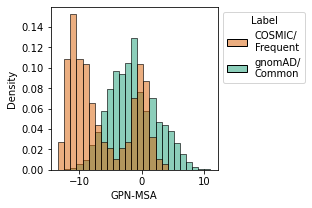

In [19]:
histplot_label(
    V_cosmic,
    hue_order=["COSMIC/\nFrequent", "gnomAD/\nCommon"],
    #save_path="hist_cosmic.svg",
)

In [10]:
rows = []
for m in tqdm(dataset_models["COSMIC"]):
    y_true = V_cosmic.label=="Frequent"
    y_score = -V_cosmic[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append([m, AUROC, AUPRC])
results_cosmic = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"]).sort_values("AUPRC", ascending=False)
results_cosmic

100%|██████████| 7/7 [00:00<00:00, 92.99it/s]


,Model,AUROC,AUPRC
0,multiz100way/89/128/64/True/defined.phastCons....,0.758951,0.347935
5,ESM-1b,0.779002,0.228049
1,CADD,0.741121,0.167130
2,phyloP,0.673162,0.140823
3,phyloP-241-mammals,0.661654,0.092083
4,phastCons-100-vertebrates,0.656855,0.032126
6,NT,0.570730,0.020556


In [11]:
n_pos, n_neg = (V_cosmic.label=="Frequent").sum(), (V_cosmic.label=="Common").sum()
cosmic_title = f"COSMIC frequent vs. \ngnomAD common (missense) \n n = {n_pos} vs. {n_neg}"
cosmic_pos_prop = n_pos/(n_pos+n_neg)
cosmic_title

'COSMIC frequent vs. \ngnomAD common (missense) \n n = 189 vs. 13117'

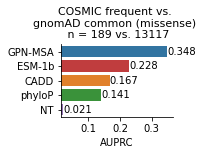

In [12]:
barplot(
    results_cosmic[results_cosmic.Model.isin([
        models[0], "CADD", "phyloP", "ESM-1b", "NT",
    ])].replace(models[0], "GPN-MSA"),
    "AUPRC",
    cosmic_title,
    pos_prop=cosmic_pos_prop,
    figsize=(2,2*2/3),
    #save_path="cosmic_auprc.svg",
)

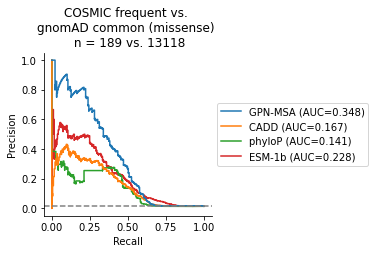

In [28]:
plot_curve(
    V_cosmic,
    results_cosmic[results_cosmic.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "ESM-1b",
    ])],
    "PR",
    title,
    pos_label="Frequent",
    pos_prop=pos_prop,
    save_path="cosmic_pr_curve.svg",
)

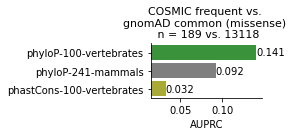

In [32]:
barplot(
    results_cosmic[results_cosmic.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    "AUPRC",
    cosmic_title,
    pos_prop=cosmic_pos_prop,
    figsize=(2,2*1/2),
    #save_path="cosmic_auprc_conservation.svg",
)

## OMIM pathogenic vs. gnomAD common (regulatory)

In [13]:
omim_variant_type_dict = {
    "5_prime_UTR_variant": "5' UTR",
    "upstream_gene_variant": "Promoter",
    "intergenic_variant": "Enhancer",
    "3_prime_UTR_variant": "3' UTR",
    "non_coding_transcript_exon_variant": "ncRNA",
}
cs = list(omim_variant_type_dict.keys())
cs

['5_prime_UTR_variant',
 'upstream_gene_variant',
 'intergenic_variant',
 '3_prime_UTR_variant',
 'non_coding_transcript_exon_variant']

In [14]:
V_omim = V[
    (V.source == "OMIM") |
    (
        (V.label == "Common") &
        np.any([V.consequence.str.contains(c) for c in cs], axis=0) &
        ~V.consequence.str.contains("missense")
    )
].copy()
V_omim.label.value_counts()

label
Common        2321067
Pathogenic        406
Name: count, dtype: int64

In [15]:
V_omim.loc[V_omim.source=="OMIM", "consequence"] = V_omim[V_omim.source=="OMIM"].consequence.str.split(" ").str[:-1].str.join(sep=" ").str.replace("’", "'").replace("RNA Gene", "ncRNA")

In [16]:
for x, y in omim_variant_type_dict.items():
    V_omim[y] = False
    V_omim.loc[(V_omim.source=="OMIM") & (V_omim.consequence==y), y] = True
    V_omim.loc[(V_omim.source!="OMIM") & (V_omim.consequence.str.contains(x)), y] = True

In [17]:
def get_subtitle(c, n_pathogenic, n_common):
    return f"{c}\nn={n_pathogenic} vs. {n_common}"

pos_prop = []

consequence_models = dataset_models["OMIM"]

rows = []
for c in consequence_models:
    V_c = V_omim.copy() if c=="all" else V_omim[V_omim[c]].copy()
    V_c.dropna(subset=consequence_models[c], inplace=True)
    
    if c == "all":
        V_omim_all = V_c
    
    n_pos, n_neg = (V_c.label=="Pathogenic").sum(), (V_c.label=="Common").sum()
    subtitle = get_subtitle(c, n_pos, n_neg)
    pos_prop.append(n_pos/(n_pos+n_neg))
    
    for m in tqdm(consequence_models[c]):
        AUROC = roc_auc_score(V_c.label=="Pathogenic", -V_c[m])
        AUPRC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
        rows.append([m, c, AUROC, AUPRC, subtitle])
results_omim = pd.DataFrame(rows, columns=["Model", "Consequence", "AUROC", "AUPRC", "subtitle"])
results_omim

100%|██████████| 5/5 [00:00<00:00, 10.04it/s]


,Model,Consequence,AUROC,AUPRC,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,all,0.927967,0.115803,all\nn=406 vs. 2284702
1,CADD,all,0.936614,0.032636,all\nn=406 vs. 2284702
2,phyloP,all,0.869517,0.038891,all\nn=406 vs. 2284702
3,phyloP-241-mammals,all,0.881639,0.028575,all\nn=406 vs. 2284702
4,phastCons-100-vertebrates,all,0.835147,0.005967,all\nn=406 vs. 2284702
5,multiz100way/89/128/64/True/defined.phastCons....,Promoter,0.934323,0.044576,Promoter\nn=130 vs. 820082
6,CADD,Promoter,0.926675,0.014447,Promoter\nn=130 vs. 820082
7,phyloP,Promoter,0.881289,0.011281,Promoter\nn=130 vs. 820082
8,phyloP-241-mammals,Promoter,0.897380,0.021060,Promoter\nn=130 vs. 820082
9,phastCons-100-vertebrates,Promoter,0.859121,0.005709,Promoter\nn=130 vs. 820082


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

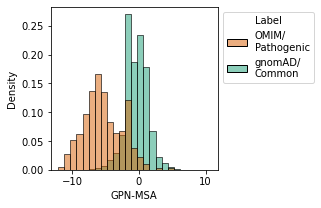

In [55]:
histplot_label(
    V_omim_all,
    hue_order=["OMIM/\nPathogenic", "gnomAD/\nCommon"],
    #save_path="hist_omim.svg",
)

In [18]:
replacements = {"Promoter": "promoter", "Enhancer": "enhancer"}

for key, value in replacements.items():
    results_omim['subtitle'] = results_omim['subtitle'].str.replace(key, value)

In [19]:
def omim_plot(
    df,
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    g = sns.catplot(
        data=df,
        y="Model",
        x="AUPRC",
        col="subtitle",
        height=1.5,
        aspect=1.0,
        kind="bar",
        col_wrap=3,
        sharex=False,
        sharey=True,
        legend=False,
        palette=palette,
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}");
    for i, ax in enumerate(g.axes):
        ax.set_xlim(left=pos_prop[i])
        ax.set_ylabel("")
    g.fig.suptitle(title, y=y, fontsize=12, x=x)
    g.figure.subplots_adjust(wspace=1.0, hspace=1.0)

    for ax in g.axes.flat:
        for bar in ax.patches:
            ax.text(
                bar.get_width(),  # X position, here at the end of the bar
                bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
                f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
                va='center'  # Vertical alignment
            )
    
    """
    # Get current x-tick labels
    catplot = g
    current_labels = [item.get_text() for item in catplot.ax.get_xticklabels()]

    # Convert to float and format with desired number of significant figures
    n_significant_figures = 2
    formatted_labels = [f"{float(label):.{n_significant_figures}g}" if label.replace('.','',1).isdigit() else label for label in current_labels]

    # Set new labels
    catplot.set_xticklabels(formatted_labels)
    """

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


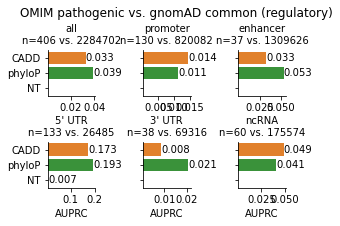

In [20]:
omim_plot(
    results_omim[results_omim.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "NT",
    ])],
    x=0.6,
    #save_path="omim_auprc.svg",
)

In [37]:
title = "OMIM pathogenic vs.\ngnomAD common (regulatory)" + "\n" + results_omim[results_omim.Consequence=="all"].subtitle.iloc[0]

In [38]:
def omim_curve_plot(
    subset_models,
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    consequence_models = dataset_models["OMIM"]
    plot_f = PrecisionRecallDisplay
    metric = "AUPRC"
    xlabel = 'Recall'
    ylabel = 'Precision'
    pos_label = "Pathogenic"

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 5))
    
    rows = []
    i = 0
    for c in consequence_models:
        ax = axes.flat[i]
        V_c = V_omim.copy() if c=="all" else V_omim[V_omim[c]].copy()
        V_c.dropna(subset=consequence_models[c], inplace=True)

        n_pos, n_neg = (V_c.label=="Pathogenic").sum(), (V_c.label=="Common").sum()
        pos_prop = n_pos/(n_pos+n_neg)
        subtitle = get_subtitle(c, n_pos, n_neg)

        for m in np.array(consequence_models[c])[::-1]:
            if m not in subset_models: continue
            AUC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
            plot_f.from_predictions(V_c.label==pos_label, -V_c[m], name=m, ax=ax, label=f"{m}\n(AUC={AUC:.3f})", color=palette[m])

        ax.axhline(y=pos_prop, linestyle="--", color="gray")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        sns.despine()

        ax.legend();
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # reverse the order
        handles, labels = handles[::-1], labels[::-1]
        # create the legend with the reversed order
        ax.legend(handles, labels)#, loc='center left', bbox_to_anchor=(1, 0.5))    

        ax.set_title(subtitle)
        i += 1
    
    fig.suptitle(title, y=y, fontsize=12, x=x)
    plt.subplots_adjust(hspace=0.5) 

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

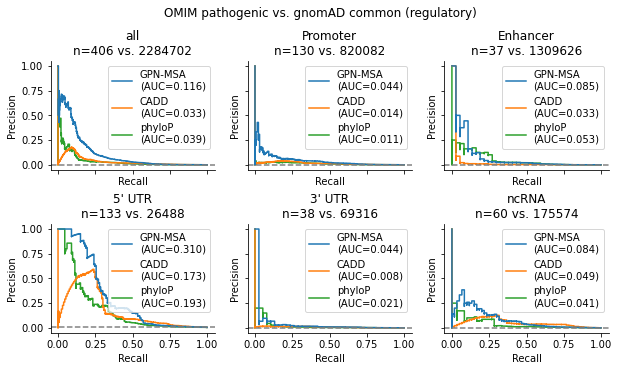

In [39]:
omim_curve_plot(
    subset_models=["GPN-MSA", "CADD", "phyloP"],
    save_path="omim_pr_curves.svg",
)

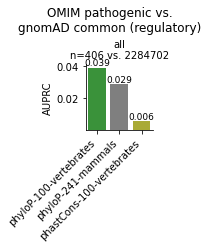

In [57]:
omim_plot(
    results_omim[(results_omim.Consequence=="all") & results_omim.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    title="OMIM pathogenic vs.\ngnomAD common (regulatory)",
    x=0.2, y=1.15,
    #save_path="omim_auprc_conservation.svg",
)

## gnomAD rare vs. common

In [21]:
V_gnomad = V[V.source == "gnomAD"].copy()
V_gnomad.label.value_counts()

label
Rare      4869209
Common    4869209
Name: count, dtype: int64

In [22]:
# Drop 32 variants with MAF 1/n but AF > 0.5
# In the case of GPN-MSA and other LLR-based methods, it would be easy
# to include these variants in the analysis by "folding" (considering the major as the reference)
# (flipping the scores when AF > 0.5)
# but CADD and phyloP are only computed assuming a fixed ref
V_gnomad = V_gnomad[V_gnomad.AC != V_gnomad.AN - 1].copy()
V_gnomad.label.value_counts()

label
Common    4869209
Rare      4869177
Name: count, dtype: int64

In [23]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    if threshold == df[model_name].max():  # happens with SpliceAI
        print("WARNING: threshold == max(score)", threshold_quantile, model_name)
        return None, None, None, None, None, None
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    odds_ratio, p_value, min_counts, ci_lower, ci_upper = _compute_odds_ratio(df)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper, threshold

def _compute_odds_ratio(df):
    group_counts = df.groupby(["label", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [['Common', 'High'],
         ['Common', 'Low'],
         ['Rare', 'High'],
         ['Rare', 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    #if np.isinf(odds_ratio):
    #    print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [24]:
threshold_quantiles = np.logspace(-5, -1, 21)
#threshold_quantiles = np.logspace(-2, 0, 11)[:-1]

consequence_models = dataset_models["gnomAD"]

rows = []
for c in list(consequence_models.keys()):
    #if c != "missense": continue  # temporary
    #if c != "all": continue  # temporary
    if c not in ["missense", "synonymous", "5_prime_UTR", "3_prime_UTR"]: continue
    
    print(c)
    if c == "all":
        df_c = V_gnomad
    else:
        df_c = V_gnomad[V_gnomad.consequence.str.contains(c)]
        # optional filter
        if c != "missense": df_c = df_c[~df_c.consequence.str.contains("missense")]
        
    df_c = df_c.dropna(subset=consequence_models[c])
    
    if c == "all":
        #df_c.to_parquet("subset_4_gnomad_vs_gnomad.parquet", index=False)
        #print(len(df_c))
        V_gnomad_all = df_c
        #raise Exception("debug")
    # optional subsample
    #df_c = df_c.groupby("label").sample(n=df_c.label.value_counts().min(), random_state=42).sample(frac=1, random_state=42)
    
    for m in tqdm(consequence_models[c]):
        subtitle = get_subtitle(c, (df_c.label=="Rare").sum(), (df_c.label=="Common").sum())
        for tq in threshold_quantiles:
            if m in ablation_models[1:] and tq != 1e-3: continue
            OR, p_value, min_counts, cil, ciu, threshold = compute_odds_ratio(df_c[[m, "label"]], tq, m)
            rows.append([m, c, tq, OR, p_value, min_counts, cil, ciu, threshold, subtitle])
results_gnomad = pd.DataFrame(rows, columns=["Model", "Consequence", "Quantile threshold", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "Threshold", "subtitle"])
results_gnomad

missense


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


synonymous


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


5_prime_UTR


100%|██████████| 6/6 [00:03<00:00,  1.74it/s]


3_prime_UTR


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


,Model,Consequence,Quantile threshold,Odds ratio,p_value,min_counts,cil,ciu,Threshold,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,missense,0.000010,inf,7.421568e-01,0,NaN,inf,-13.425033,missense\nn=37755 vs. 13117
1,multiz100way/89/128/64/True/defined.phastCons....,missense,0.000016,inf,7.421568e-01,0,NaN,inf,-13.399463,missense\nn=37755 vs. 13117
2,multiz100way/89/128/64/True/defined.phastCons....,missense,0.000025,inf,5.507929e-01,0,NaN,inf,-13.367619,missense\nn=37755 vs. 13117
3,multiz100way/89/128/64/True/defined.phastCons....,missense,0.000040,inf,4.087691e-01,0,NaN,inf,-13.325368,missense\nn=37755 vs. 13117
4,multiz100way/89/128/64/True/defined.phastCons....,missense,0.000063,inf,3.033646e-01,0,NaN,inf,-13.215473,missense\nn=37755 vs. 13117
...,...,...,...,...,...,...,...,...,...,...
520,NT,3_prime_UTR,0.015849,2.002135,2.907494e-58,716,1.830324,2.190073,-5.022718,3_prime_UTR\nn=82954 vs. 69316
521,NT,3_prime_UTR,0.025119,1.882833,1.876689e-76,1188,1.754389,2.020681,-4.619185,3_prime_UTR\nn=82954 vs. 69316
522,NT,3_prime_UTR,0.039811,1.780767,6.612692e-100,1965,1.683995,1.883101,-4.261152,3_prime_UTR\nn=82954 vs. 69316
523,NT,3_prime_UTR,0.063096,1.715117,1.240088e-135,3217,1.640434,1.793199,-3.937277,3_prime_UTR\nn=82954 vs. 69316


/tmp/ipykernel_2801289/2596275445.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V["Label"] = V.source + "/\n" + V.label
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaf

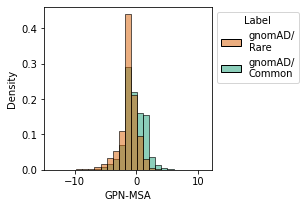

In [ ]:
histplot_label(
    V_gnomad_all,
    hue_order=["gnomAD/\nRare", "gnomAD/\nCommon"],
    #save_path="hist_gnomad.svg",
)

(0.0, 0.007)

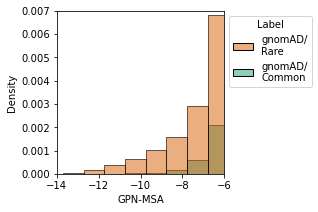

In [116]:
histplot_label(
    V_gnomad_all,
    hue_order=["gnomAD/\nRare", "gnomAD/\nCommon"],
)
plt.xlim(-14, -6)
plt.ylim(0, 7e-3)
#plt.savefig(plot_dir + "hist_gnomad_zoom.svg", bbox_inches="tight")

In [41]:
print("Careful if inf, should handle separately: ", results_gnomad["Odds ratio"].max())

Careful if inf, should handle separately:  89.25922147651006


In [25]:
limit_per_consequence = results_gnomad.query("min_counts < 10").groupby("Consequence")["Quantile threshold"].max()
limit_per_consequence

Consequence
3_prime_UTR    0.001585
5_prime_UTR    0.003981
missense       0.025119
synonymous     0.002512
Name: Quantile threshold, dtype: float64

In [26]:
def above_limit(r):
    try:
         l = limit_per_consequence[r.Consequence]
    except:
        return True
    return r["Quantile threshold"] > l

results_gnomad["above_limit"] = results_gnomad.apply(above_limit, axis=1)

In [27]:
results_gnomad[results_gnomad.above_limit].min_counts.min()

12

In [28]:
results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min()

0.002511886431509582

In [29]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "non_coding_transcript_exon": "ncRNA",
}

for key, value in replacements.items():
    results_gnomad['subtitle'] = results_gnomad['subtitle'].str.replace(key, value)
    results_gnomad['Consequence'] = results_gnomad['Consequence'].str.replace(key, value)

In [30]:
x = results_gnomad.subtitle.drop_duplicates()
x = "``" + results_gnomad.Consequence.drop_duplicates() + "'': " + x.str.split('\n').str[-1].str.replace("n=", "$n=$ ")
x = ", ".join(x.values)
x

"``missense'': $n=$ 37755 vs. 13117, ``synonymous'': $n=$ 18645 vs. 17565, ``5' UTR'': $n=$ 35515 vs. 26485, ``3' UTR'': $n=$ 82954 vs. 69316"

In [31]:
def gnomad_plot(df, save_path=None, y=1.15, height=2.1):
    g = sns.relplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        col="subtitle",
        #col="Consequence",
        height=height,
        kind="line",
        marker="o",
        col_wrap=min(5, len(df.subtitle.unique())),
        facet_kws={'sharey': False, 'sharex': False},
        palette=palette,
        markersize=5,
    )

    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=1.0)
    g.fig.subplots_adjust(
        hspace=1.2,
        #wspace=0.5,
    ) # 1.0 # modification
    plt.suptitle("gnomAD rare vs. common", y=y);
    for ax in g.axes.flat:
        xticks = df[(df.p_value<=0.05) & (df.above_limit)]["Quantile threshold"].drop_duplicates().values
        xticks = xticks[::2]
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{x:.2e}" for x in xticks])

    #    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
        ax.tick_params(axis='x', rotation=45)

    """
    for ax, subtitle in zip(g.axes.flat, g.col_names):
        ax.set_title(ax.get_title(), fontweight='bold')
        
        xticks = [1e-4, 1e-3, 1e-2, 1e-1]
        ax.set_xticks(xticks)
        left = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min() * 0.8
        right = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].max() / 0.8
        ax.set_xlim(left=left, right=right)
        ax.set_xlabel("Quantile threshold")

        secax = ax.secondary_xaxis('top')
        secax.set_xscale('log')
        secax.set_xticks(xticks)
        subset_df = df[(df['Consequence'] == subtitle) & (df['Model'] == "GPN-MSA")]
        tick_labels = [
            subset_df[
                np.isclose(subset_df["Quantile threshold"], tq)
            ].Threshold.values[0]
            for tq in xticks
        ]
        tick_labels = [f"{x:.1f}" for x in tick_labels]
        secax.set_xticklabels(tick_labels)
        secax.set_xlabel("GPN-MSA score")
    """
  
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

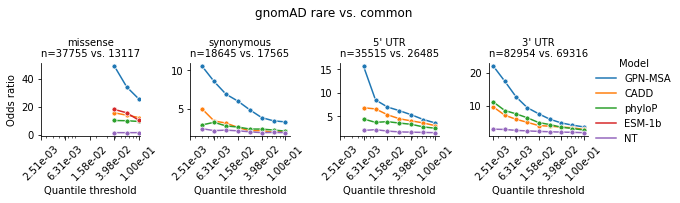

In [35]:
import warnings
warnings.filterwarnings('ignore')
gnomad_plot(
    results_gnomad[results_gnomad.Model.isin([
        models[0], "CADD", "phyloP", "ESM-1b", "SpliceAI", "NT",
    ])].replace(models[0], "GPN-MSA"),
    y=1.13,
    #save_path="gnomad_or.svg",
    #save_path="gnomad_or_missense.pdf",
)

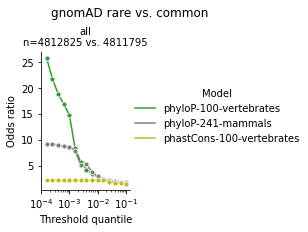

In [90]:
gnomad_plot(
    results_gnomad[(results_gnomad.Consequence=="all") & results_gnomad.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    y=1.25, height=2.5,
    #save_path="gnomad_or_conservation.svg",
)

## gnomAD Enformer set (low-frequency vs. common)

In [161]:
V_enformer = V_enformer[V_enformer.AF < 0.95]
V_enformer["label"] = "Common"
V_enformer.loc[V_enformer.AF < 0.05, "label"] = "Rare"  # for convenience, actually low-frequency
V_enformer.label.value_counts()

label
Rare      3589541
Common    2733438
Name: count, dtype: int64

In [166]:
threshold_quantiles = np.logspace(-5, -1, 21)

rows = []

df_c = V_enformer.dropna(subset=models_enformer)

for m in tqdm(models_enformer):
    for tq in threshold_quantiles:
        OR, p_value, min_counts, cil, ciu, threshold = compute_odds_ratio(df_c[[m, "label"]], tq, m)
        rows.append([m, tq, OR, p_value, min_counts, cil, ciu, threshold])
results_enformer = pd.DataFrame(rows, columns=["Model", "Quantile threshold", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "Threshold"])
results_enformer

100%|██████████| 8/8 [08:00<00:00, 60.03s/it]


,Model,Quantile threshold,Odds ratio,p_value,min_counts,cil,ciu,Threshold
0,multiz100way/89/128/64/True/defined.phastCons....,0.000010,4.581095,7.919088e-07,9,2.229671,9.412345,-9.988813
1,multiz100way/89/128/64/True/defined.phastCons....,0.000016,4.635664,4.460667e-10,14,2.603645,8.253576,-9.594156
2,multiz100way/89/128/64/True/defined.phastCons....,0.000025,4.481585,8.118485e-15,23,2.854272,7.036682,-9.281250
3,multiz100way/89/128/64/True/defined.phastCons....,0.000040,3.369524,9.314497e-17,46,2.430696,4.670964,-8.995733
4,multiz100way/89/128/64/True/defined.phastCons....,0.000063,2.923843,2.606757e-21,82,2.281567,3.746923,-8.695312
...,...,...,...,...,...,...,...,...
163,Enformer_linf,0.015849,1.109611,6.151662e-58,40403,1.095242,1.124169,-0.101257
164,Enformer_linf,0.025119,1.089844,3.599367e-62,64691,1.078580,1.101224,-0.077393
165,Enformer_linf,0.039811,1.081657,2.896735e-80,103098,1.072710,1.090678,-0.058197
166,Enformer_linf,0.063096,1.071810,1.620383e-96,164331,1.064681,1.078987,-0.043030


In [167]:
n_pos, n_neg = (df_c.label=="Rare").sum(), (df_c.label=="Common").sum()
title = f"gnomAD low-frequency vs. common\n(upstream, downstream, intergenic)"  #\nn={n_pos} vs. {n_neg}"
title

'gnomAD low-frequency vs. common\n(upstream, downstream, intergenic)'

In [168]:
limit = results_enformer.query("min_counts < 10")["Quantile threshold"].max()
limit

9.999999999999999e-06

In [169]:
def above_limit(r):
    return np.isnan(limit) or r["Quantile threshold"] > limit + 1e-8

results_enformer["above_limit"] = results_enformer.apply(above_limit, axis=1)

In [182]:
def enformer_plot(df, save_path=None):
    plt.figure(figsize=(2,2))
    g = sns.lineplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        marker="o",
        palette=palette,
        markersize=5,
    )
    #for ax in g.axes: ax.axhline(1, ls='--', color="grey")
    #g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=0.75)
    #plt.suptitle("gnomAD rare vs. common", y=0.9);
    sns.despine()
    #ax.set_ylim(bottom=pos_prop[i])
    plt.ylim(bottom=1)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    #g.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    
    ax = g     
    xticks = [1e-4, 1e-3, 1e-2, 1e-1]
    ax.set_xticks(xticks)

    if "GPN-MSA" in df.Model.unique():
        secax = ax.secondary_xaxis('top')
        secax.set_xscale('log')
        secax.set_xticks(xticks)
        subset_df = df[(df['Model'] == "GPN-MSA")]
        tick_labels = [
            subset_df[
                np.isclose(subset_df["Quantile threshold"], tq)
            ].Threshold.values[0]
            for tq in xticks
        ]
        tick_labels = [f"{x:.1f}" for x in tick_labels]
        secax.set_xticklabels(tick_labels)
        secax.set_xlabel("GPN-MSA score")

    plt.title(title, fontsize=11);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

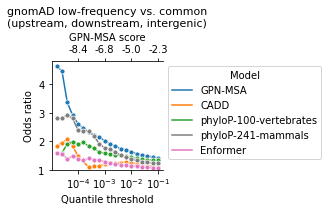

In [186]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
        models[0], "CADD", "phyloP", "Enformer_l1", "phyloP-241-mammals",
    ])].replace({"Enformer_l1": "Enformer", "phyloP": "phyloP-100-vertebrates", models[0]: "GPN-MSA"}),
    #save_path="gnomad_or_enformer.svg",
)

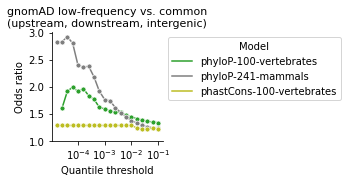

In [184]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    #save_path="gnomad_or_enformer_conservation.svg",
)

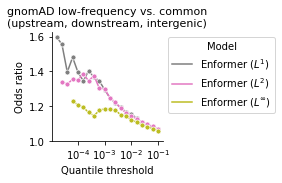

In [185]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
        "Enformer_l1", "Enformer_l2", "Enformer_linf",
    ])].replace({
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    #save_path="gnomad_or_enformer_norms.pdf",
)

## GWAS

In [84]:
V_gwas = V_gwas.dropna(subset=models_gwas)
V_gwas = V_gwas[V_gwas.duplicated("match_group", keep=False)]

In [85]:
gwas_c_count = V_gwas.consequence.value_counts()
gwas_c_count

consequence
intron_variant                         1958
missense_variant                        576
intergenic_variant                      484
upstream_gene_variant                   250
non_coding_transcript_exon_variant      166
3_prime_UTR_variant                     156
downstream_gene_variant                 138
5_prime_UTR_variant                     106
synonymous_variant                       64
splice_region_variant                    22
stop_gained                              16
splice_polypyrimidine_tract_variant      12
splice_donor_5th_base_variant             6
splice_donor_region_variant               4
splice_donor_variant                      2
Name: count, dtype: int64

In [86]:
gwas_cs = ['all'] + (gwas_c_count[gwas_c_count >= 2 * 30]).index.values.tolist()
gwas_cs

['all',
 'intron_variant',
 'missense_variant',
 'intergenic_variant',
 'upstream_gene_variant',
 'non_coding_transcript_exon_variant',
 '3_prime_UTR_variant',
 'downstream_gene_variant',
 '5_prime_UTR_variant',
 'synonymous_variant']

In [87]:
for m in [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]:
    if m in V_gwas.columns:
        print(m)
        V_gwas[m] = -V_gwas[m].abs()

multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True


In [88]:
V_gwas2 = V_gwas.copy()
#V_gwas2 = V_gwas[~V_gwas.INFO.str.contains("missense")]  # optional
#V_gwas2 = V_gwas[V_gwas.disease_trait]

sample_size = {}
rows = []

# Separate by chrom
"""
for c in tqdm(["all"] + gwas_cs.tolist()):
    V_gwas3 = V_gwas2.copy() if c == "all" else V_gwas2[V_gwas2.consequence==c]
    sample_size[c] = 0
    for chrom in V_gwas3.chrom.unique():
        V_c = V_gwas3[V_gwas3.chrom==chrom]
        V_c = V_c.dropna(subset=models_gwas)
        V_c = V_c[V_c.duplicated("match_group", keep=False)]
        n_pos = V_c.label.sum()
        if n_pos == 0: continue
        sample_size[c] += n_pos
        for m in models_gwas:
            rows.append([c, chrom, m, roc_auc_score(V_c.label, -V_c[m])])
results_gwas = pd.DataFrame(rows, columns=["Consequence", "Chrom", "Model", "AUROC"])
results_gwas
"""

# All chroms together
for c in tqdm(gwas_cs):
    V_gwas3 = V_gwas2.copy() if c == "all" else V_gwas2[V_gwas2.consequence==c]
    sample_size[c] = 0
    for chrom in V_gwas3.chrom.unique():
        V_c = V_gwas3[V_gwas3.chrom==chrom]
        n_pos = V_c.label.sum()
        if n_pos == 0: continue
        sample_size[c] += n_pos
        for m in models_gwas:
            rows.append([c, chrom, m, roc_auc_score(V_c.label, -V_c[m]), n_pos])
results_gwas = pd.DataFrame(rows, columns=["Consequence", "Chrom", "Model", "AUROC", "n_pos"])
results_gwas

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


,Consequence,Chrom,Model,AUROC,n_pos
0,all,1,multiz100way/89/128/64/True/defined.phastCons....,0.599970,172
1,all,1,CADD,0.586770,172
2,all,1,phyloP,0.573688,172
3,all,1,phyloP-241-mammals,0.579874,172
4,all,1,phastCons-100-vertebrates,0.549993,172
...,...,...,...,...,...
2455,synonymous_variant,22,InstaDeepAI/nucleotide-transformer-2.5b-multi-...,1.000000,2
2456,synonymous_variant,22,LongSafari/hyenadna-large-1m-seqlen-hf.Logisti...,1.000000,2
2457,synonymous_variant,22,multiz100way/89/128/64/True/defined.phastCons....,1.000000,2
2458,synonymous_variant,22,multiz100way/89/128/64/True/defined.phastCons....,0.750000,2


In [89]:
# weighted average of different chroms
results_gwas = results_gwas.groupby(["Consequence", "Model"]).apply(lambda df: (df.AUROC * (df.n_pos / df.n_pos.sum())).sum()).rename("AUROC").reset_index()

In [90]:
results_gwas_main = results_gwas[~results_gwas.Model.isin(
    [f"{m}.LogisticRegression" for m in ablation_models] + models[:1]
)]
results_gwas_main = results_gwas_main[
    ~results_gwas_main.Model.str.contains("BestFeature") &
    ~results_gwas_main.Model.str.contains("SumFeatures") &
    (results_gwas_main.Model != models[0])
]
results_gwas_main.Model = results_gwas_main.Model.str.replace(".LogisticRegression", "")
results_gwas_main.Model = [model_renaming.get(m, m) for m in results_gwas_main.Model]
results_gwas_main.Model = results_gwas_main.Model.replace(models[0], "GPN-MSA")
results_gwas_main.Model = results_gwas_main.Model.replace(models[0] + "/concat/Enformer", "GPN-MSA + Enformer")
results_gwas_main

,Consequence,Model,AUROC
0,3_prime_UTR_variant,CADD,0.638248
1,3_prime_UTR_variant,Enformer,0.619231
2,3_prime_UTR_variant,NT,0.631517
3,3_prime_UTR_variant,HyenaDNA,0.696474
6,3_prime_UTR_variant,GPN-MSA,0.785150
...,...,...,...
114,upstream_gene_variant,GPN-MSA,0.680133
116,upstream_gene_variant,GPN-MSA + Enformer,0.722334
117,upstream_gene_variant,phastCons-100-vertebrates,0.568860
118,upstream_gene_variant,phyloP,0.582530


In [91]:
results_gwas_main.Model.value_counts()

Model
CADD                         10
Enformer                     10
NT                           10
HyenaDNA                     10
GPN-MSA                      10
GPN-MSA + Enformer           10
phastCons-100-vertebrates    10
phyloP                       10
phyloP-241-mammals           10
Name: count, dtype: int64

In [92]:
#title_gwas = f"UKBB GWAS causal vs. not\nn={total_n_pos} vs. {total_n_neg}"
#title_gwas

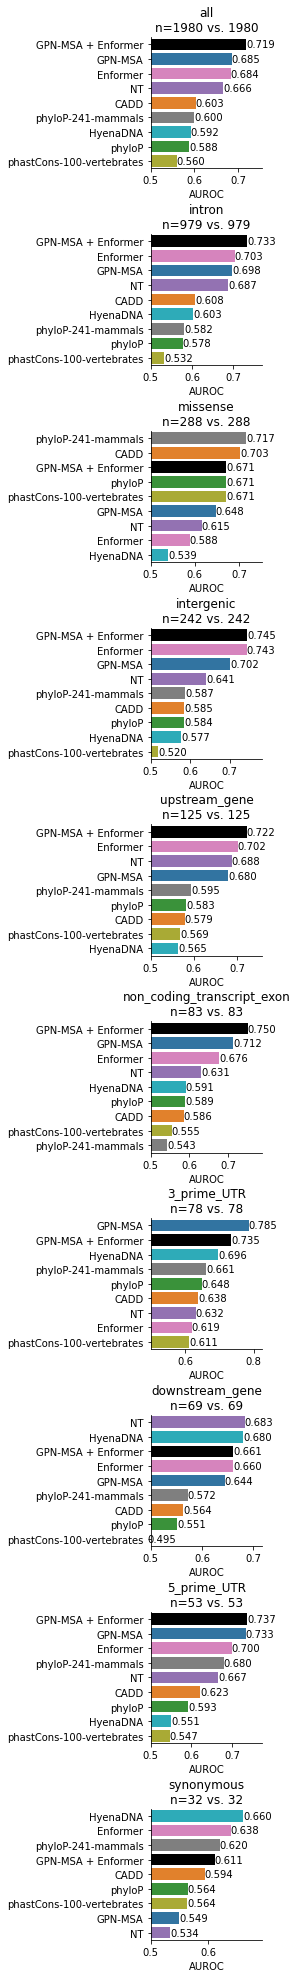

In [93]:
f, axarr = plt.subplots(len(gwas_cs), figsize=(2,3.5*len(gwas_cs)))
for c, ax in zip(gwas_cs, axarr.flatten()):
    df = results_gwas_main[results_gwas_main.Consequence==c]
    g = sns.barplot(
        data=df,
        x="AUROC", y="Model",
        ax=ax,
        palette=palette,
        order=df.groupby("Model").AUROC.mean().sort_values(ascending=False).index.values,
    )

    for bar in g.patches:
        g.text(
            bar.get_width(),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )

    #plt.title(title_gwas)
    ax.set_ylabel("")
    n = sample_size[c]
    ax.set_title(f"{c.replace('_variant', '')}\nn={n} vs. {n}")
    g.set(xlim=0.5);
    sns.despine();
f.subplots_adjust(hspace=0.5)
#plt.savefig("gwas_main.pdf", bbox_inches="tight")

In [94]:
results_gwas_supp = results_gwas[results_gwas.Model.isin([
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.BestFeature",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.SumFeatures",
])].replace({
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "Log-likelihood ratio",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression": "LogisticRegression(inner products)",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.BestFeature": "Best(inner products)",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.SumFeatures": "Sum(inner products)",
})
#results_gwas_main.Model = results_gwas_main.Model.str.replace(".LogisticRegression", "")
#results_gwas_main.Model = [model_renaming.get(m, m) for m in results_gwas_main.Model]
#results_gwas_main.Model = results_gwas_main.Model.replace(models[0], "GPN-MSA")
#results_gwas_main.Model = results_gwas_main.Model.replace(models[0] + "/concat/Enformer", "GPN-MSA + Enformer")
results_gwas_supp

,Consequence,Model,AUROC
4,3_prime_UTR_variant,Log-likelihood ratio,0.636004
5,3_prime_UTR_variant,Best(inner products),0.737286
6,3_prime_UTR_variant,LogisticRegression(inner products),0.785150
7,3_prime_UTR_variant,Sum(inner products),0.702244
16,5_prime_UTR_variant,Log-likelihood ratio,0.606132
17,5_prime_UTR_variant,Best(inner products),0.709119
18,5_prime_UTR_variant,LogisticRegression(inner products),0.733491
19,5_prime_UTR_variant,Sum(inner products),0.601415
28,all,Log-likelihood ratio,0.604427
29,all,Best(inner products),0.654660


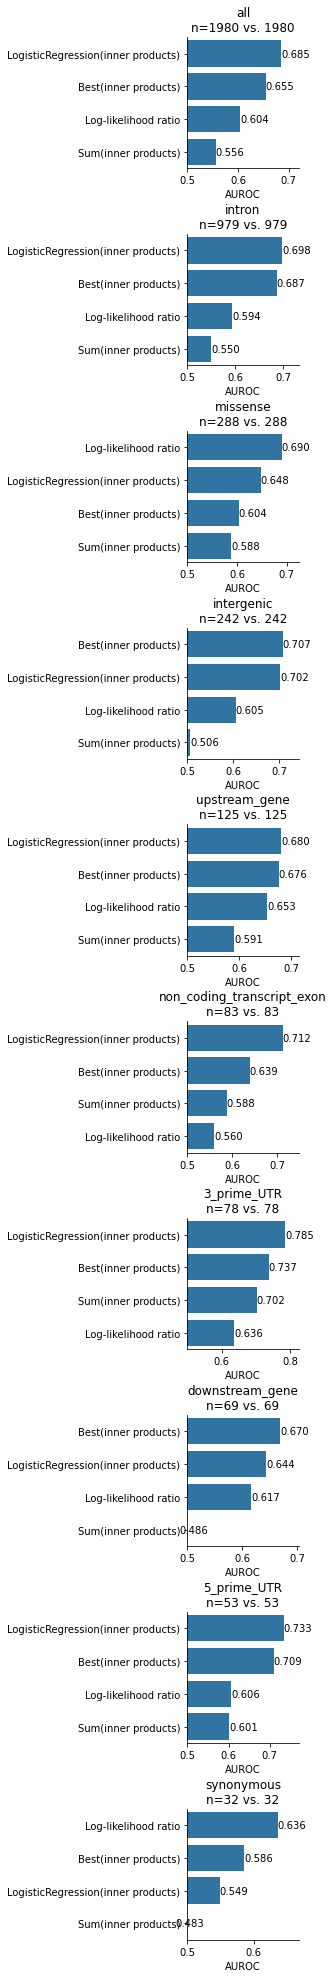

In [95]:
f, axarr = plt.subplots(len(gwas_cs), figsize=(2,3.5*len(gwas_cs)))
for c, ax in zip(gwas_cs, axarr.flatten()):
    df = results_gwas_supp[results_gwas_supp.Consequence==c]
    g = sns.barplot(
        data=df,
        x="AUROC", y="Model",
        ax=ax,
        color="C0",
        order=df.groupby("Model").AUROC.mean().sort_values(ascending=False).index.values,
    )

    for bar in g.patches:
        g.text(
            bar.get_width(),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )

    #plt.title(title_gwas)
    ax.set_ylabel("")
    n = sample_size[c]
    ax.set_title(f"{c.replace('_variant', '')}\nn={n} vs. {n}")
    g.set(xlim=0.5);
    sns.despine();
f.subplots_adjust(hspace=0.5)
#plt.savefig("gwas_gpnmsa.pdf", bbox_inches="tight")

In [10]:
disease_traits = [
    'AFib',
    'AID_Combined',
    'Alzheimer_LTFH',
    'Asthma',
    'Blood_Clot_Lung',
    'BrC',
    'CAD',
    'Cholelithiasis',
    'CRC',
    'DVT',
    'Fibroblastic_Disorders',
    'Glaucoma_Combined',
    'Hypothyroidism',
    'IBD',
    'Inguinal_Hernia',
    'LOY',
    'MCP',
    'Migraine_Self',
    'PrC',
    'T2D',
    'T2D_BMI',
]

In [11]:
len(disease_traits), len(traits), len(set(traits).intersection(set(disease_traits)))

(21, 85, 19)

In [13]:
gwas_metadata["disease_trait"] = gwas_metadata.trait.apply(lambda traits: len(set(traits).intersection(set(disease_traits))) > 0)
gwas_metadata.disease_trait.value_counts()

disease_trait
False    2208
True       91
Name: count, dtype: int64

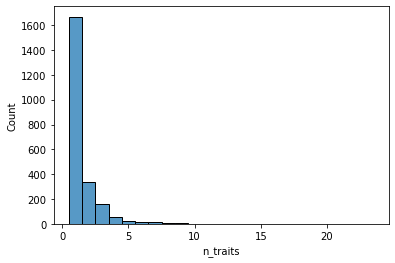

In [240]:
sns.histplot(data=gwas_metadata, x="n_traits", discrete=True);

In [253]:
models_gwas[5]

'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression'

In [255]:
models_gwas[8]

'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True/concat/Enformer.LogisticRegression'

In [256]:
V_gwas["GPN-MSA prediction"] = -V_gwas[models_gwas[5]]
V_gwas["GPN-MSA + Enformer prediction"] = -V_gwas[models_gwas[8]]

In [260]:
V_gwas.trait.iloc[0]

''

In [266]:
V_gwas["n_traits"] = V_gwas.trait.str.split(",").str.len()  # only applies to positives
V_gwas.loc[~V_gwas.label, "n_traits"] = 0

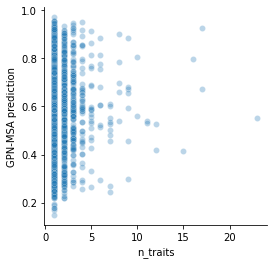

In [268]:
plt.figure(figsize=(4,4))
sns.scatterplot(
    data=V_gwas[V_gwas.label],
    x="n_traits",
    y="GPN-MSA prediction",
    alpha=0.3,
)
sns.despine();

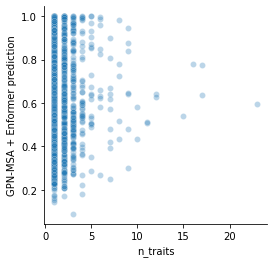

In [269]:
plt.figure(figsize=(4,4))
sns.scatterplot(
    data=V_gwas[V_gwas.label],
    x="n_traits",
    y="GPN-MSA + Enformer prediction",
    alpha=0.3,
)
sns.despine();

In [270]:
V_gwas["n_traits_bin"] = pd.cut(V_gwas.n_traits, [1, 1.99, 10, 23], include_lowest=True)

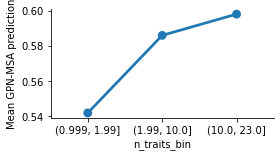

In [271]:
plt.figure(figsize=(4, 2))
sns.pointplot(
    data=V_gwas[V_gwas.label],
    x="n_traits_bin",
    y="GPN-MSA prediction",
    errorbar=None,
)
plt.ylabel("Mean GPN-MSA prediction")
sns.despine();

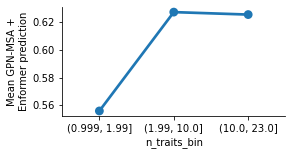

In [272]:
plt.figure(figsize=(4, 2))
sns.pointplot(
    data=V_gwas[V_gwas.label],
    x="n_traits_bin",
    y="GPN-MSA + Enformer prediction",
    errorbar=None,
)
plt.ylabel("Mean GPN-MSA +\nEnformer prediction")
sns.despine();

## Ablation study

In [106]:
results_gwas_ablation = results_gwas[
    results_gwas.Model.str.contains("LogisticRegression") &
    results_gwas.Model.str.contains("multiz")
]
results_gwas_ablation = results_gwas_ablation.groupby("Model").AUROC.mean().to_frame().reset_index()
results_gwas_ablation.Model = results_gwas_ablation.Model.str.replace(".LogisticRegression", "")
results_gwas_ablation

,Model,AUROC
0,multiz100way/89/128/64/True/defined.phastCons....,0.658057
1,multiz100way/89/128/64/True/defined.phastCons....,0.732561
2,multiz100way/89/128/64/True/defined.phastCons....,0.732494
3,multiz100way/89/128/64/True/defined.phastCons....,0.714560
4,multiz100way/89/128/64/True/defined.phastCons....,0.728183
5,multiz100way/89/128/64/True/defined.phastCons....,0.701242
6,multiz100way/89/128/64/True/defined.phastCons....,0.732140
7,multiz100way/89/128/64/True/defined.phastCons....,0.712122
8,multiz100way/89/128/64/True/defined.phastCons....,0.736330
9,multiz100way/89/128/64/True/defined.phastCons....,0.651094


In [147]:
results_ablation = [
    df[df.Model.isin(models[:1] + ablation_models)]
    for df in [
        results_clinvar[["Model", "AUROC"]].rename(columns={"AUROC": "ClinVar"}),
        results_cosmic[["Model", "AUPRC"]].rename(columns={"AUPRC": "COSMIC"}),
        results_omim[results_omim.Consequence=="all"][["Model", "AUPRC"]].rename(columns={"AUPRC": "OMIM"}),
        results_gnomad[
            (results_gnomad["Quantile threshold"]==1e-3) & (results_gnomad.Consequence=="all") 
        ][["Model", "Odds ratio"]].rename(columns={"Odds ratio": "gnomAD"}),
        results_gwas_ablation.rename(columns={"AUROC": "GWAS"}),
    ]
]

results_ablation = reduce(lambda x, y: x.merge(y, on="Model", how="left"), results_ablation)
results_ablation

,Model,ClinVar,COSMIC,OMIM,gnomAD,GWAS
0,multiz100way/89/256/128/True/defined.phastCons...,0.966573,0.357106,0.127410,36.659241,0.737470
1,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.334161,0.106964,37.105859,0.733894
2,multiz100way/89/256/128/True/defined.phastCons...,0.966203,0.368041,0.107375,37.328784,0.732380
3,multiz100way/89/256/128/True/defined.phastCons...,0.966161,0.350975,0.115069,37.874235,0.737503
4,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.348005,0.116074,38.350315,0.736330
5,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.342592,0.122366,35.517883,0.733602
6,multiz100way/89/128/64/True/defined.phastCons....,0.965504,0.325528,0.097476,35.949228,0.729384
7,multiz100way/89/128/64/True/defined.phastCons....,0.965352,0.334579,0.116613,34.462112,0.729037
8,multiz100way/89/128/64/True/defined.phastCons....,0.965173,0.342336,0.107573,36.987425,0.732140
9,multiz100way/89/128/64/True/defined.phastCons....,0.964764,0.303342,0.112456,34.056944,0.732652


In [148]:
hparam_name = {
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Default",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/False/True/True": "w/o MSA",
    "msa_multiz100way/89": "MSA frequency (no neural net)",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/[\d]+/30000/True/True/True": "Train on 50% most conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_1.00_0.00/medium/0.1/[\d]+/30000/True/True/True": "Train on 100% of genome",
    
    r"multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Include closest primates",
    r"multiz100way_mammals/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 mammals",
    r"multiz100way_vertebrates/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 vertebrates",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/False/True": "Don't upweight conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/False": "Don't replace non-conserved",
    
    r"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 256",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.64": "Window size = 64",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.32": "Window size = 32",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.16": "Window size = 16",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.8": "Window size = 8",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.4": "Window size = 4",
}

In [149]:
results_ablation["Ablation"] = None
for k, v in hparam_name.items():
    results_ablation.loc[results_ablation.Model.str.match(k), "Ablation"] = v
results_ablation = results_ablation.dropna(subset="Ablation")
results_ablation.Ablation.value_counts()

Ablation
Window size = 256                3
Default                          3
Window size = 64                 3
Don't upweight conserved         3
Window size = 32                 3
Don't replace non-conserved      3
51 vertebrates                   3
51 mammals                       3
Window size = 16                 3
Train on 50% most conserved      3
Window size = 8                  3
Train on 100% of genome          3
Include closest primates         3
Window size = 4                  3
w/o MSA                          3
MSA frequency (no neural net)    1
Name: count, dtype: int64

In [150]:
results_ablation = results_ablation.groupby("Ablation")[["ClinVar", "COSMIC", "OMIM", "gnomAD", "GWAS"]].agg(["mean", "std"])
results_ablation.index.name = None
results_ablation = results_ablation.loc[hparam_name.values()]
results_ablation = results_ablation.round(3)
results_ablation

ClinVar        COSMIC          OMIM         \
                                 mean    std   mean    std   mean    std   
Default                         0.966  0.000  0.342  0.007  0.115  0.008   
w/o MSA                         0.582  0.001  0.014  0.000  0.000  0.000   
MSA frequency (no neural net)   0.947    NaN  0.266    NaN  0.030    NaN   
Train on 50% most conserved     0.960  0.001  0.237  0.020  0.122  0.012   
Train on 100% of genome         0.957  0.001  0.207  0.014  0.119  0.002   
Include closest primates        0.950  0.002  0.211  0.007  0.128  0.018   
51 mammals                      0.962  0.001  0.317  0.002  0.067  0.002   
51 vertebrates                  0.964  0.000  0.334  0.005  0.090  0.007   
Don't upweight conserved        0.964  0.000  0.297  0.006  0.122  0.016   
Don't replace non-conserved     0.964  0.000  0.328  0.006  0.102  0.002   
Window size = 256               0.966  0.000  0.359  0.009  0.117  0.010   
Window size = 64                0.965  0.000  0.334  0.008  0.107  0.010   
Window size = 32                0.964  0.000  0.317  0.006  0.107  0.014   
Window size = 16                0.962  0.000  0.242  0.003  0.094  0.009   
Window size = 8                 0.958  0.000  0.188  0.017  0.078  0.008   
Window size = 4                 0.938  0.001  0.134  0.020  0.049  0.002   

                               gnomAD          GWAS         
                                 mean    std   mean    std  
Default                        36.991  1.420  0.735  0.001  
w/o MSA                         1.933  0.029  0.654  0.004  
MSA frequency (no neural net)  17.344    NaN    NaN    NaN  
Train on 50% most conserved    28.690  1.102  0.732  0.002  
Train on 100% of genome        26.516  1.228  0.730  0.001  
Include closest primates       31.541  1.485  0.728  0.003  
51 mammals                     33.343  0.314  0.734  0.003  
51 vertebrates                 33.837  0.496  0.731  0.000  
Don't upweight conserved       34.162  1.032  0.732  0.000  
Don't replace non-conserved    33.122  1.685  0.733  0.001  
Window size = 256              37.287  0.609  0.736  0.003  
Window size = 64               35.800  1.269  0.730  0.002  
Window size = 32               34.945  0.612  0.726  0.003  
Window size = 16               28.581  0.691  0.717  0.003  
Window size = 8                23.325  0.349  0.712  0.000  
Window size = 4                10.182  0.298  0.702  0.001

In [153]:
categories = ["ClinVar", "COSMIC", "OMIM", "gnomAD", "GWAS"]
results_ablation_tex = pd.DataFrame()

def mean_std_str(mean, std):
    if pd.isna(mean):
        return "NA"
    elif pd.isna(std):
        return f"{mean:.3f}"
    else:
        return f"{mean:.3f} ± {std:.3f}"
    
def mean_str(mean, is_gnomad):
    if pd.isna(mean):
        return "NA"
    else:
        if is_gnomad:
            return f"{mean:.1f}"
        else:
            return f"{mean:.3f}"

for category in categories:
    mean_col = (category, "mean")
    std_col = (category, "std")
    
    results_ablation_tex[category] = results_ablation.apply(
        #lambda row: mean_std_str(row[mean_col], row[std_col]), axis=1
        lambda row: mean_str(row[mean_col], category=="gnomAD"), axis=1
    )
results_ablation_tex

,ClinVar,COSMIC,OMIM,gnomAD,GWAS
Default,0.966,0.342,0.115,37.0,0.735
w/o MSA,0.582,0.014,0.000,1.9,0.654
MSA frequency (no neural net),0.947,0.266,0.030,17.3,NA
Train on 50% most conserved,0.960,0.237,0.122,28.7,0.732
Train on 100% of genome,0.957,0.207,0.119,26.5,0.730
Include closest primates,0.950,0.211,0.128,31.5,0.728
51 mammals,0.962,0.317,0.067,33.3,0.734
51 vertebrates,0.964,0.334,0.090,33.8,0.731
Don't upweight conserved,0.964,0.297,0.122,34.2,0.732
Don't replace non-conserved,0.964,0.328,0.102,33.1,0.733


In [154]:
print(results_ablation_tex.to_latex(escape="latex"))

\begin{tabular}{llllll}
\toprule
 & ClinVar & COSMIC & OMIM & gnomAD & GWAS \\
\midrule
Default & 0.966 & 0.342 & 0.115 & 37.0 & 0.735 \\
w/o MSA & 0.582 & 0.014 & 0.000 & 1.9 & 0.654 \\
MSA frequency (no neural net) & 0.947 & 0.266 & 0.030 & 17.3 & NA \\
Train on 50\% most conserved & 0.960 & 0.237 & 0.122 & 28.7 & 0.732 \\
Train on 100\% of genome & 0.957 & 0.207 & 0.119 & 26.5 & 0.730 \\
Include closest primates & 0.950 & 0.211 & 0.128 & 31.5 & 0.728 \\
51 mammals & 0.962 & 0.317 & 0.067 & 33.3 & 0.734 \\
51 vertebrates & 0.964 & 0.334 & 0.090 & 33.8 & 0.731 \\
Don't upweight conserved & 0.964 & 0.297 & 0.122 & 34.2 & 0.732 \\
Don't replace non-conserved & 0.964 & 0.328 & 0.102 & 33.1 & 0.733 \\
Window size = 256 & 0.966 & 0.359 & 0.117 & 37.3 & 0.736 \\
Window size = 64 & 0.965 & 0.334 & 0.107 & 35.8 & 0.730 \\
Window size = 32 & 0.964 & 0.317 & 0.107 & 34.9 & 0.726 \\
Window size = 16 & 0.962 & 0.242 & 0.094 & 28.6 & 0.717 \\
Window size = 8 & 0.958 & 0.188 & 0.078 & 23.3 & 0.712 

In [207]:
results_ablation_tex[results_ablation_tex.index != "MSA frequency (no neural net)"].astype(float).corr(method="spearman")

,ClinVar,COSMIC,OMIM,gnomAD,GWAS
ClinVar,1.000000,0.955735,0.283918,0.931463,0.722453
COSMIC,0.955735,1.000000,0.254480,0.930234,0.785842
OMIM,0.283918,0.254480,1.000000,0.429339,0.443548
gnomAD,0.931463,0.930234,0.429339,1.000000,0.737032
GWAS,0.722453,0.785842,0.443548,0.737032,1.000000
